In [1]:
import os 
import tensorflow as tf
import numpy as np
from nets import RNNC
from tqdm import tqdm
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

name="task2_dset"
data, labels = np.load(name+"/data.npy"), np.load(name+"/label.npy")

stoppings = []
for k in range(4):
    for kk in range(10**k,10**(k+1),10**k):
        stoppings.append(kk)
for j in range(1,4):
    stoppings.append(j*10**4)


100%|██████████| 30001/30001 [09:21<00:00, 53.39it/s]


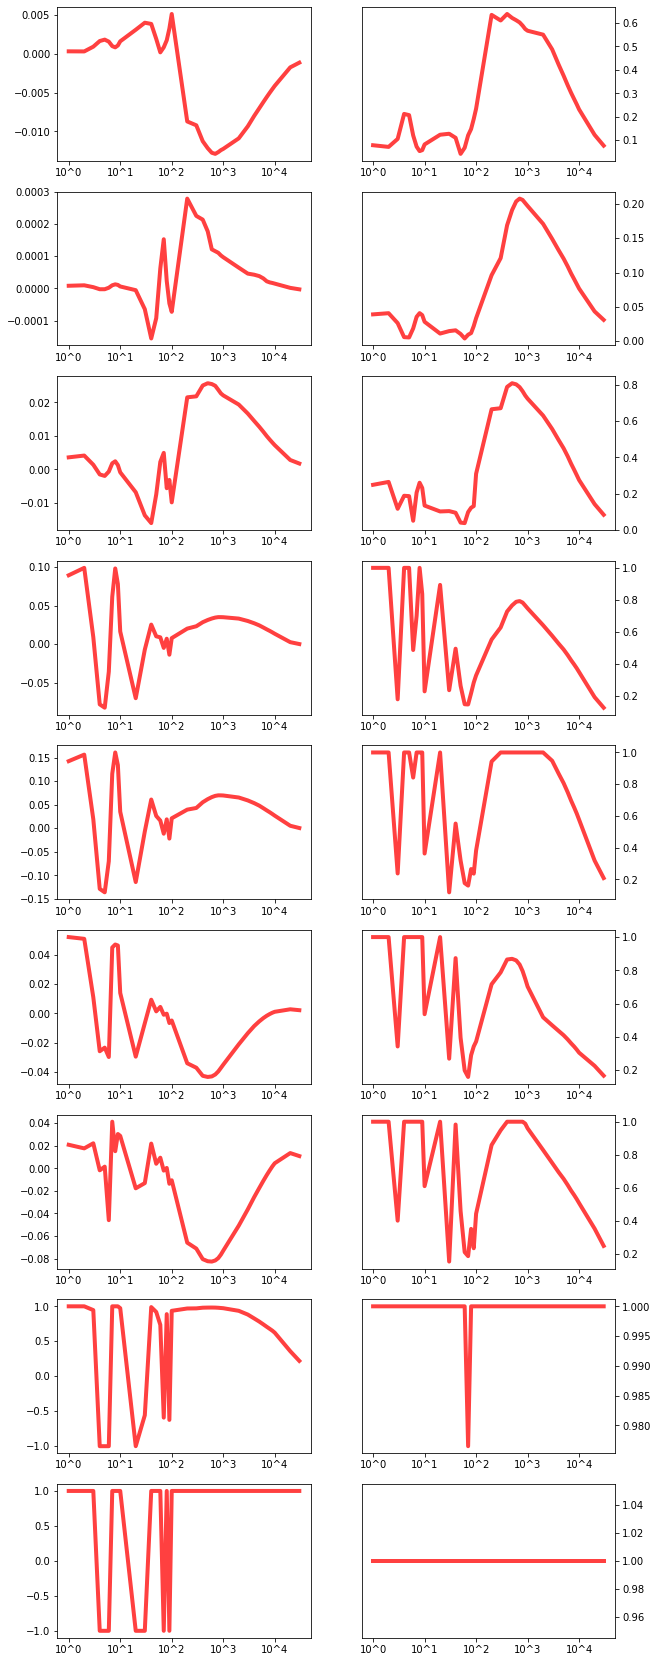

In [2]:
dons = []
for lmm in [1,2]:
    net = RNNC(seed_val=0.5,lmode=lmm)
    if not os.path.exists("grads_{}".format(lmm)):
        os.makedirs("grads_{}".format(lmm))
    l=[]
    for k in tqdm(range((3*10**4)+1)):
        if k in stoppings:
            lo, gr = net.train_step(data, labels, return_gradients=True)
            np.save("grads_{}/{}".format(lmm,k),gr)
            net.save_weights("net_{}/".format(lmm)+str(k))        
            dons.append(k)
            l.append(lo)
        else:
            lo =net.train_step(data, labels) 
            l.append(lo)
    os.system("python3 image_gen.py --names {}".format(lmm))
    means=[]
    maxs=[]
    for ep in dons:
        gr = np.load("grads_{}/{}.npy".format(lmm,ep), allow_pickle=True)
        means.append([np.mean(gr[ko].numpy()) for ko in range(len(gr))])
        maxs.append([np.max(np.abs(gr[ko].numpy())) for ko in range(len(gr))])    


    ti=[]
    for kkk in np.log10(dons):
        if kkk in list(range(10)):
            ti.append(kkk)

    plt.figure(figsize=(10,30))
    axs={}
    for ik in range(9):
        axs[str(ik)] = plt.subplot2grid((9,2),(ik,0))
        axs[str(ik)].plot(np.log10(dons),np.array(means)[:,ik], label="mean gradient at layer {}".format(ik), color="red",alpha=0.75, linewidth=4)
        axs[str(ik)].set_xticks(ti)    
        axs[str(ik)].set_xticklabels(["10^{}".format(int(kik)) for kik in ti])
        if k==0:
            axs[str(ik)].set_title("mean value of gradient \nat each layer", size=20)
        axs[str(ik)] = plt.subplot2grid((9,2),(ik,1))
        axs[str(ik)].plot(np.log10(dons),np.array(maxs)[:,ik], label="max absolute value of gradient at layer {}".format(ik), color="red",alpha=0.75, linewidth=4)
        axs[str(ik)].set_xticks(ti)    
        axs[str(ik)].yaxis.tick_right()
        axs[str(ik)].set_xticklabels(["10^{}".format(int(kik)) for kik in ti])
        if k==0:
            axs[str(ik)].set_title("max abs value of gradient \nat each layer", size=20)
    plt.savefig("evolution_lmm_{}.png".format(lmm))